## Imports & methods for plotting graphs

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import math

from keras import backend
from keras import Input

from keras.layers import concatenate, Dense, BatchNormalization
from keras.models import Model, Sequential

# for generating a png image of our model
from keras.utils import plot_model
from IPython.display import Image

Using TensorFlow backend.


In [2]:
# disable the `SettingWithCopy` because we are pretty sure we know what we are doing
pd.set_option('mode.chained_assignment', None) 

In [3]:
# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)
# method taken from `Deep Learning with Python` by François Chollet

def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [4]:
# Plot model history more easily

def set_plot_history_data(ax, history, which_graph):

    if which_graph == 'acc':
        train = smooth_curve(history.history['acc'])
        valid = smooth_curve(history.history['val_acc'])

    if which_graph == 'loss':
        train = smooth_curve(history.history['loss'])
        valid = smooth_curve(history.history['val_loss'])

    plt.xkcd() # make plots look like xkcd
        
    epochs = range(1, len(train) + 1)
        
    trim = 0 # remove first 5 epochs
    # when graphing loss the first few epochs may skew the (loss) graph
    
    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', label=('Training'))
    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', linewidth=15, alpha=0.1)
    
    ax.plot(epochs[trim:], valid[trim:], 'g', label=('Validation'))
    ax.plot(epochs[trim:], valid[trim:], 'g', linewidth=15, alpha=0.1)

    
def get_max_validation_accuracy(history):
    validation = smooth_curve(history.history['val_acc'])
    ymax = max(validation)
    return 'Max validation accuracy ≈ ' + str(round(ymax, 3)*100) + '%'

In [5]:
def plot_history(history):    
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,
                                   ncols=1,
                                   figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw = {'height_ratios':[5, 2]})

    set_plot_history_data(ax1, history, 'acc')
    
    set_plot_history_data(ax2, history, 'loss')
    
    # Accuracy graph
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(bottom=0.5, top=1)
    ax1.legend(loc="lower right")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis.set_ticks_position('none')
    ax1.spines['bottom'].set_visible(False)
    
    # max accuracty text
    plt.text(0.97,
             0.97,
             get_max_validation_accuracy(history),
             horizontalalignment='right',
             verticalalignment='top',
             transform=ax1.transAxes,
             fontsize=12)

    # Loss graph
    ax2.set_ylabel('Loss')
    ax2.set_yticks([])
    ax2.plot(legend=False)
    ax2.set_xlabel('Epochs')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()

# Sort images into correct categories

In [6]:
from keras import models
from keras import layers

from keras import backend

In [7]:
import os

base_dir = '../../images/sorted'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.2,
    zoom_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 90 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 3)


follows the `cat-dog.py` file

In [13]:
backend.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [14]:
model.summary()

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/5
100/100 [==============================] - 57s 574ms/step - loss: 0.9833 - acc: 0.5055 - val_loss: 1.0746 - val_acc: 0.5520
Epoch 2/5
100/100 [==============================] - 50s 503ms/step - loss: 0.8258 - acc: 0.6190 - val_loss: 0.8964 - val_acc: 0.6360
Epoch 3/5
100/100 [==============================] - 50s 501ms/step - loss: 0.7326 - acc: 0.6735 - val_loss: 0.7993 - val_acc: 0.6510
Epoch 4/5
100/100 [==============================] - 50s 504ms/step - loss: 0.6338 - acc: 0.7140 - val_loss: 0.7634 - val_acc: 0.7000
Epoch 5/5
100/100 [==============================] - 53s 528ms/step - loss: 0.5727 - acc: 0.7390 - val_loss: 0.7512 - val_acc: 0.7030


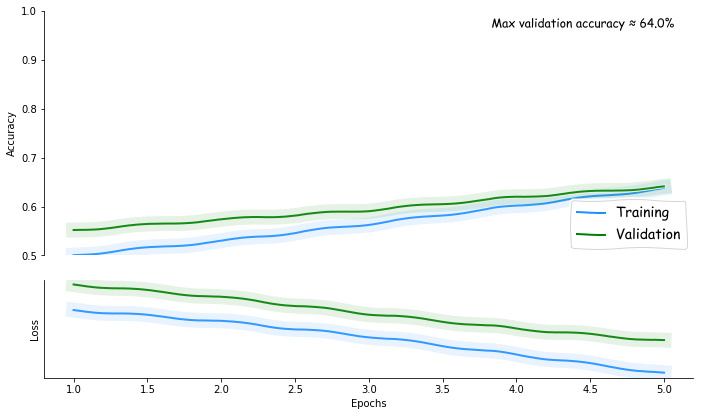

In [16]:
plot_history(history)

In [17]:
# model.save('3_image_categories.h5')